In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import GaussianBlur
import numpy as np
import torchvision as T
import tqdm
import matplotlib.pyplot as plt
from scipy import signal
from torchsummary import summary
from PIL import Image

In [2]:
import torch
import torch.nn as nn
import numpy as np
import torchvision as T
import tqdm
import matplotlib.pyplot as plt
import os
import sys
import gdown
from zipfile import ZipFile
import pandas as pd

In [3]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
my_local_drive='/content/gdrive/My Drive/Deeplearning/dl/CNN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

/content/gdrive/My Drive/Deeplearning/dl/CNN


'/content/gdrive/My Drive/Deeplearning/dl/CNN'

In [5]:
df = pd.read_csv("people.csv")

In [62]:
#retreive all images
X=[]
root = "lfw_dataset/lfw-deepfunneled/lfw-deepfunneled/"
for person in df["name"]:
  if type(person) != str:
    break
  X.append(Image.open(root+person+"/"+person+"_0001.jpg"))

In [63]:
X = torch.tensor(np.array([np.array(x.resize((50,50))) for x in X]))

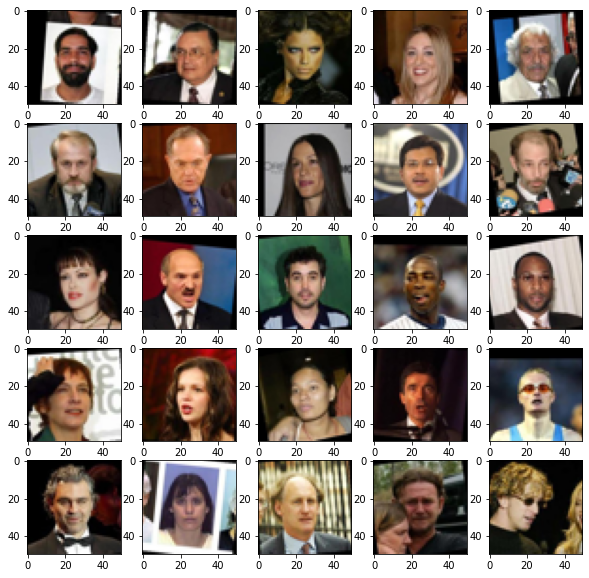

In [64]:
plt.figure(figsize=(10,10))
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.imshow(X[i].detach().numpy())

In [38]:
print(X.shape)
print(X.permute(0,3,1,2).shape)

torch.Size([601, 100, 100, 3])
torch.Size([601, 3, 100, 100])


In [65]:
Xs=torch.tensor(np.array(X)).permute(0,3,1,2) / 255.

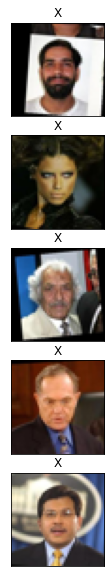

In [66]:
#visualize
plt.figure(figsize=(5,10))
for i in range(1,11,2):
  plt.subplot(5,2,i)
  plt.title("X")
  plt.gca().get_xaxis().set_visible(False)
  plt.gca().get_yaxis().set_visible(False)
  plt.imshow(Xs.permute(0,2,3,1).detach()[i])

In [152]:
class Model(nn.Module):
  def __init__(self,commitment):
    super().__init__()
    self.embedding_num = 32*32
    self.commitment = commitment

    self.conv1 =  nn.Conv2d(3,40,3,(2,2))
    self.b1 = nn.BatchNorm2d(40)
    self.conv2 =  nn.Conv2d(40,40,3,(2,2))
    self.b2 = nn.BatchNorm2d(40)
    self.conv3 =  nn.Conv2d(40,40,2,(2,2))

    self.embedding = nn.Embedding(self.embedding_num,10)
    self.embedding.weight.data.uniform_(-1./10,1./10)


    self.deconv = nn.ConvTranspose2d(40,45,3,2)
    self.b3 = nn.BatchNorm2d(45)
    self.deconv2 = nn.ConvTranspose2d(45,35,4,2)
    self.b4 = nn.BatchNorm2d(35)
    self.deconv3 = nn.ConvTranspose2d(35,13,2,2)
    self.b5 = nn.BatchNorm2d(13)
    self.deconv4 = nn.ConvTranspose2d(13,3,3,1)

  def forward(self,x):
    x = self.conv1(x)
    x = self.b1(x)
    x = nn.functional.relu(x)
    x = self.conv2(x)
    x = self.b2(x)
    x = nn.functional.relu(x)
    x = self.conv3(x)
    x = nn.functional.relu(x)
    x = torch.reshape(x,(len(x),5*5*40))

    
    encoding = x.reshape(len(x),100,10)
    embeddingWeights = self.embedding.weight.reshape((1,self.embedding_num,10))

    #calcul des plus proches
    embedding_squares = torch.sum(embeddingWeights**2,dim=2)
    encoding_squares = torch.sum(encoding**2,dim=2)
    distances = (encoding_squares.reshape((len(x),-1,1)) + embedding_squares
                + torch.matmul(encoding,embeddingWeights.transpose(1,2).float()))

    argmin = torch.argmin(distances,dim=2)
    argminMatrix = torch.nn.functional.one_hot(argmin,self.embedding_num).float()
    closestVectors = torch.matmul(argminMatrix,embeddingWeights.float())

    l = (nn.functional.mse_loss(closestVectors,encoding.detach())
        +self.commitment * nn.functional.mse_loss(encoding,closestVectors.detach()))

    x = nn.Unflatten(dim=1,unflattened_size=(40,5,5))(x)
    x = self.deconv(x)
    x = self.b3(x)
    x = nn.functional.relu(x)
    x = self.deconv2(x)
    x = self.b4(x)
    x = nn.functional.relu(x)
    x = self.deconv3(x)
    x = self.b5(x)
    x = nn.functional.relu(x)
    x = self.deconv4(x)

    

    return x,l,embeddingWeights

In [147]:
model = Model(.25)
summary(model,(3,50,50))

tensor(0.1335, grad_fn=<AddBackward0>)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 24, 24]           1,120
       BatchNorm2d-2           [-1, 40, 24, 24]              80
            Conv2d-3           [-1, 40, 11, 11]          14,440
       BatchNorm2d-4           [-1, 40, 11, 11]              80
            Conv2d-5             [-1, 40, 5, 5]           6,440
   ConvTranspose2d-6           [-1, 45, 11, 11]          16,245
       BatchNorm2d-7           [-1, 45, 11, 11]              90
   ConvTranspose2d-8           [-1, 35, 24, 24]          25,235
       BatchNorm2d-9           [-1, 35, 24, 24]              70
  ConvTranspose2d-10           [-1, 13, 48, 48]           1,833
      BatchNorm2d-11           [-1, 13, 48, 48]              26
  ConvTranspose2d-12            [-1, 3, 50, 50]             354
Total params: 66,013
Trainable params: 66,013
Non-trainable para

In [148]:
def create_the_model(commitment):
  model = Model(commitment)
  loss = nn.MSELoss()
  opt = torch.optim.Adam(model.parameters(),lr=0.001)
  return model,loss,opt

In [159]:
def train_the_model(X_train, y_train, mb_size, nb_epochs):
  trainacc = []
  testacc = []
  lastew=None
  model.training=True
  minibatch_X = [X_train[k:k+mb_size] for k in range(0,len(X_train), mb_size)]
  minibatch_y = [y_train[k:k+mb_size] for k in range(0,len(y_train), mb_size)]
  for i in tqdm.trange(nb_epochs):
    for (X_b,y_b) in zip(minibatch_X,minibatch_y):
      pred,ls,ew = model(X_b)
      print(ew[0][0][0])
      l = ((pred-X_b)**2).sum().float() + ls.float()
      trainacc.append(l.item())

      opt.zero_grad()
      l.backward()
      opt.step()

    if lastew==None:
      lastew=ew
    print(torch.norm(lastew - ew))
    lastew = ew



  return trainacc

In [160]:
model,loss,opt = create_the_model(0.2)
trainacc= train_the_model(Xs,Xs,32,16)

  0%|          | 0/16 [00:00<?, ?it/s]

tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)


  6%|▋         | 1/16 [00:02<00:44,  2.97s/it]

tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(0., grad_fn=<CopyBackwards>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0766, grad_fn=<SelectBackward0>)
tensor(-0.0760, grad_fn=<SelectBackward0>)
tensor(-0.0754, grad_fn=<SelectBackward0>)


 12%|█▎        | 2/16 [00:06<00:42,  3.01s/it]

tensor(0., grad_fn=<CopyBackwards>)


KeyboardInterrupt: ignored

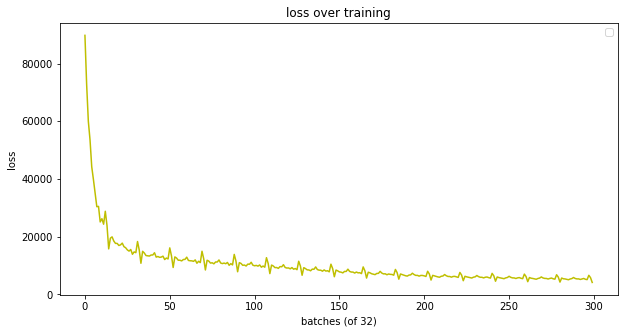

In [133]:
plt.figure(figsize=(10,5))
plt.title("loss over training")
plt.plot(trainacc[4:],"y")
plt.xlabel("batches (of 32)")
plt.ylabel("loss")

plt.legend()

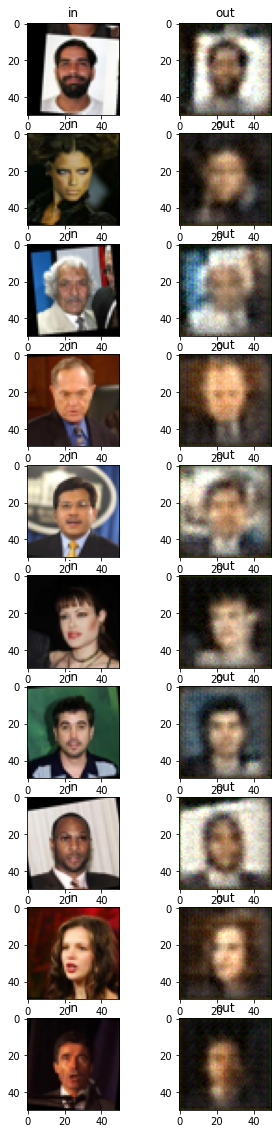

In [134]:
res = model(Xs[:20])[0]
plt.figure(figsize=(5,20))
for i in range(1,20,2):
  plt.subplot(10,2,i)
  plt.title("in")
  plt.imshow(Xs.permute(0,2,3,1)[i].detach().numpy())
  plt.subplot(10,2,i+1)
  plt.title("out")
  plt.imshow(res.permute(0,2,3,1)[i].detach().numpy())